In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2

### Предобработка данных. Генерация новых признаков.

In [5]:
def preprocessing(data:pd.DataFrame) -> pd.DataFrame:
    data = new_data(data)
    data['diff'] = data['target'].diff()
    data = lagged(data, [1, 7], 'target')
    data = lagged(data, [1, 7], 'diff')
    return data.drop(['diff'], axis=1).set_index('date').dropna()

In [6]:
def new_data(data:pd.DataFrame) -> pd.DataFrame:
    data["target"] = data.groupby(['date'])[['target']].transform(('sum'))
    data["temp_pred"] = data.groupby(['date'])[['temp_pred']].transform(('mean'))
    data = data[['date', 'target', 'temp_pred']]
    return data.drop_duplicates()

In [7]:
def lagged(data:pd.DataFrame, lags:list, name_column:str) -> pd.DataFrame:
    for i in lags:
        data[f'{name_column}_lag{i}'] = data[name_column].shift(periods=i)
    return data

In [8]:
df_train = pd.read_csv('./../data/train_dataset.csv')
df_test = pd.read_csv('./../data/test_dataset.csv')

df = preprocessing(pd.concat([df_train, df_test], axis=0))

test_size = df_test.shape[0]//24
size = df.shape[0]
train_size = size -test_size

df_train, df_test = df.iloc[:train_size,:], df.iloc[train_size:,:]

In [7]:
print(f'all - train: {df.shape[0]-df_train.shape[0]}\n test: {df_test.shape[0]}')

all - train: 122
 test: 122


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 2023-04-01 to 2023-07-31
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       122 non-null    float64
 1   temp_pred    122 non-null    float64
 2   target_lag1  122 non-null    float64
 3   target_lag7  122 non-null    float64
 4   diff_lag1    122 non-null    float64
 5   diff_lag7    122 non-null    float64
dtypes: float64(6)
memory usage: 6.7+ KB


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1543 entries, 2019-01-09 to 2023-03-31
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       1543 non-null   float64
 1   temp_pred    1543 non-null   float64
 2   target_lag1  1543 non-null   float64
 3   target_lag7  1543 non-null   float64
 4   diff_lag1    1543 non-null   float64
 5   diff_lag7    1543 non-null   float64
dtypes: float64(6)
memory usage: 84.4+ KB


In [ ]:
X = df_train.drop(['target'], axis = 1)
y = df_train['target']

X_test = df_test.drop(['target'], axis = 1)
y_test = df_test['target']

### Подбор параметров и обучение модели.

In [13]:
X = df_train.drop(['target'], axis = 1)
y = df_train['target']

X_test = df_test.drop(['target'], axis = 1)
y_test = df_test['target']

In [14]:
def objective(trial):

    train_size = int(len(X) * 0.8)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    param = {
        'iterations' : trial.suggest_int("iterations", 100, 1500),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
       'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param, loss_function='MAE')

    cb.fit(X_train, y_train, verbose=0, early_stopping_rounds=300)

    preds = cb.predict(X_test)
    accuracy = r2(y_test, preds)

    return accuracy

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2023-10-22 19:47:45,592] A new study created in memory with name: no-name-5ea9235b-4b91-4c94-8f81-590df6846c70
[I 2023-10-22 19:47:48,368] Trial 0 finished with value: 0.979838500330145 and parameters: {'iterations': 977, 'learning_rate': 0.015170322135778019, 'depth': 4, 'l2_leaf_reg': 0.1016457157545163, 'bootstrap_type': 'Bayesian', 'random_strength': 5.5874856328402445e-08, 'bagging_temperature': 0.36218239161060817, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 0 with value: 0.979838500330145.
[I 2023-10-22 19:47:54,951] Trial 1 finished with value: 0.9648902638656709 and parameters: {'iterations': 1262, 'learning_rate': 0.0037927638016019543, 'depth': 7, 'l2_leaf_reg': 0.029995013360522894, 'bootstrap_type': 'Bayesian', 'random_strength': 1.467216764804454e-08, 'bagging_temperature': 9.283368897560116, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 0 with value: 0.979838500330145.
[I 2023-10-22 19:47:57,530] Trial 2 finished with value: 0.9789191785113114 and paramete

In [17]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.9822352273219545
  Params: 
    iterations: 649
    learning_rate: 0.04251436855782874
    depth: 4
    l2_leaf_reg: 1.1014520129772767e-08
    bootstrap_type: Bayesian
    random_strength: 2.875839520359937
    bagging_temperature: 1.1752369123807553
    od_type: Iter
    od_wait: 15


In [18]:
cat = CatBoostRegressor(verbose = 0, loss_function='MAE', iterations = 649,
 learning_rate =  0.04251436855782874,
 depth = 4,
 l2_leaf_reg =   1.1014520129772767e-08,
 bootstrap_type = 'Bayesian',
 random_strength = 2.875839520359937,
 bagging_temperature =  1.1752369123807553,
 od_type = 'Iter',
 od_wait = 15)

### Валидация. Значимость признаков.

In [ ]:
def time_cross_validate(x, y, model, n_folds = 14):

    errors_test = []
    errors_train = []
    step = int(len(x) / n_folds) - 1
    for i in range(n_folds):

        model.fit(x[: step * (1 + i)], y[: step * (1 + i)])

        predictions = model.predict(x[step * (i + 1): step * (2 + i)])
        actual = y[step * (i + 1): step * (2 + i)]
        error = mae(predictions, actual)
        print('MAE = {}'.format(error))
        errors_test.append(error)

        predictions = model.predict(x[: step * (1 + i)])
        actual = y[: step * (1 + i)]
        error = mae(predictions, actual)
        errors_train.append(error)
    plt.grid(True)
    plt.plot([x for x in range(len(errors_train))], errors_train, color = 'red', label = 'train')
    plt.plot([x for x in range(len(errors_test))], errors_test, color = 'blue', label = 'test')
    plt.xlim(0)
    plt.legend()
    plt.show()

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df_train.drop(['target'], axis = 1).columns)[sorted_idx])
    plt.title('Feature Importance');

    return np.mean(np.array(errors_test))

MAE = 688.426593506112
MAE = 334.67503780375034
MAE = 195.28996769657147
MAE = 393.30085798830504
MAE = 206.64052035643988
MAE = 285.1623066693924
MAE = 269.91190934535547
MAE = 140.12346833332762
MAE = 308.19505958545074
MAE = 237.36888612434367
MAE = 176.10543418155257
MAE = 179.4052046093463
MAE = 223.3866966091017
MAE = 254.35276704951994


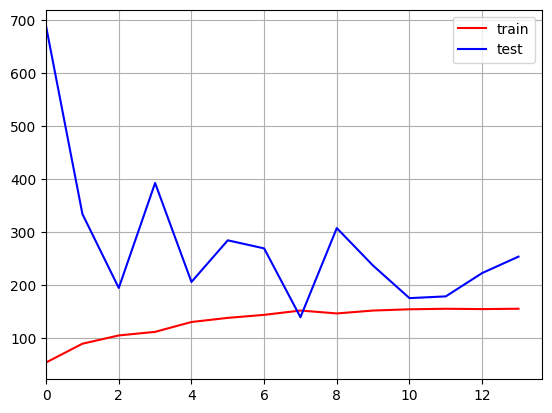

278.0246221327549

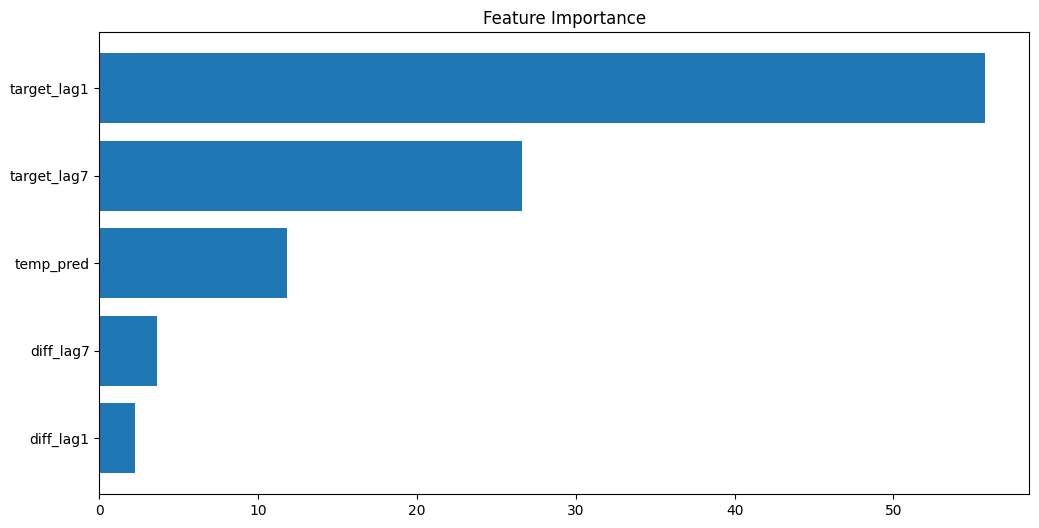

In [24]:
time_cross_validate(X, y, cat, n_folds = 14)

### Метрики на тестовом и тренировочном наборах.

In [25]:
print('mae test = {}'.format(mae(cat.predict(X_test), y_test)))

mae test = 173.29291141714


In [26]:
print('mae train = {}'.format(mae(cat.predict(X), y)))

mae train = 157.16685653698443


In [27]:
print('mape test = {}'.format(mape(cat.predict(X_test), y_test)))

mape test = 0.0168027782217422


In [28]:
print('mape train = {}'.format(mape(cat.predict(X), y)))

mape train = 0.013694168425606314


In [29]:
print('r2 test = {}'.format(r2(cat.predict(X_test), y_test)))

r2 test = 0.9354355952688138


In [30]:
print('r2 train = {}'.format(r2(cat.predict(X), y)))

r2 train = 0.9840980898108405


### Визуальное сравнение предсказания с истиными значениями на тестовом и тренировочном наборах.

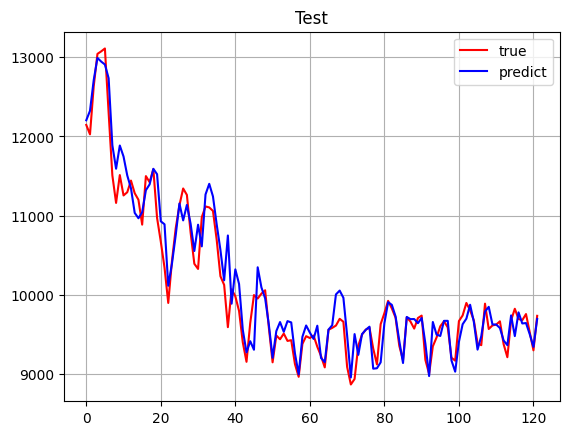

In [38]:
plt.grid(True)
plt.title('Test')
plt.plot(list(y_test)[:], color = 'red', label = 'true')
plt.plot(list(cat.predict(X_test))[:], color = 'blue', label = 'predict')
plt.legend()
plt.show()

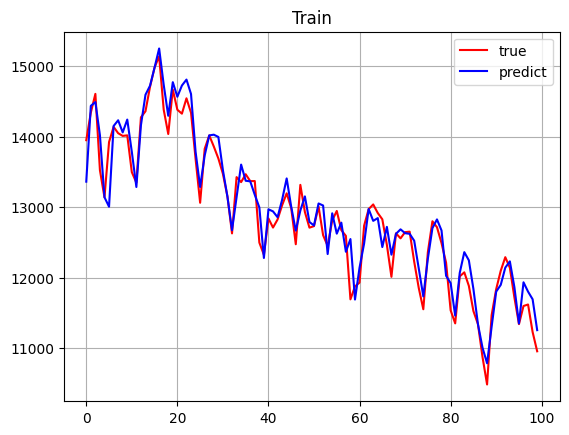

In [40]:
plt.grid(True)
plt.title('Train')
plt.plot(list(y)[:100], color = 'red', label = 'true')
plt.plot(list(cat.predict(X))[:100], color = 'blue', label = 'predict')
plt.legend()
plt.show()

### Финальная модель

In [41]:
# final model
cat = CatBoostRegressor(verbose = 0, loss_function='MAE', iterations = 649,
 learning_rate =  0.04251436855782874,
 depth = 4,
 l2_leaf_reg =   1.1014520129772767e-08,
 bootstrap_type = 'Bayesian',
 random_strength = 2.875839520359937,
 bagging_temperature =  1.1752369123807553,
 od_type = 'Iter',
 od_wait = 15)

In [44]:
X_all = concat([X, X_test])
y_all = concat([y, y_test])

In [43]:
X_all

,temp_pred,target_lag1,target_lag7,diff_lag1,diff_lag7
date,,,,,
2019-01-09,-0.500,13185.565,11547.210,465.630,420.344
2019-01-10,-3.500,13949.530,12235.564,763.965,688.354
2019-01-11,-2.750,14339.844,12763.044,390.314,527.480
2019-01-12,0.750,14606.295,12735.145,266.451,-27.899
2019-01-13,2.125,13522.839,12744.419,-1083.456,9.274
...,...,...,...,...,...
2023-07-27,17.125,9692.021,9621.374,-129.586,10.371
2023-07-28,15.625,9676.911,9663.067,-15.110,41.693
2023-07-29,19.500,9754.812,9373.196,77.901,-289.871


In [45]:
cat.fit(X_all, y_all)

In [46]:
print('mae all = {}'.format(mae(cat.predict(X_all), y_all)))

mae all = 158.08676069544742


In [49]:
 # save into pickle
 pkl_filename = "cat_optuna.pkl"
 with open(pkl_filename, 'wb') as file:
    pickle.dump(cat, file)